<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/FFSSD_with_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import tqdm
import torch
import matplotlib
import torchvision
import numpy as np
import torchsummary
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import model_selection
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

clear_output()
tf.__version__

'2.12.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip \*.zip && rm *.zip
clear_output()

In [ ]:
IMAGE_PATH = '/content/data/images/'
ANNOTATION_PATH =  '/content/data/annotations/'

os.makedirs('/content/data/', exist_ok=True)
os.replace('/content/images', '/content/data/images')
os.replace('/content/annotations', '/content/data/annotations')

##Data

In [ ]:
def parse_annotation(data_dir, img_size, limit=20):

  img_paths  = []
  gdt_bboxes = []
  gdt_classes= []
  img_w, img_h = img_size

  for img_name in os.listdir(data_dir+'images'):

    img_path = os.path.join(data_dir, 'images', img_name)
    annotation_path = os.path.join(data_dir, 'annotations', img_name[:-3]+'xml')

    with open(annotation_path, 'r') as f:
      tree = ET.parse(f)

    root = tree.getroot()
    img_paths.append(img_path)
    ann_size = root.find('size')
    orig_w = int(ann_size.find('width').text)
    orig_h = int(ann_size.find('height').text)
    ground_truth_bboxes = []
    ground_truth_classes = []
    
    for box in root.findall('object'):
      box_root = box.find('bndbox')
      xmin = float(box_root.find('xmin').text) * img_w / orig_w
      ymin = float(box_root.find('ymin').text) * img_h / orig_h
      xmax = float(box_root.find('xmax').text) * img_w / orig_w
      ymax = float(box_root.find('ymax').text) * img_h / orig_h
      bbox = torch.Tensor([int(xmin), int(ymin), int(xmax), int(ymax)])

      ground_truth_bboxes.append(bbox.tolist())
      ground_truth_classes.append(int(root.find('segmented').text))

    gdt_bboxes.append(torch.Tensor(ground_truth_bboxes[:limit]))
    gdt_classes.append(torch.Tensor(ground_truth_classes[:limit]))
    
  return gdt_bboxes, gdt_classes, img_paths[:limit]

In [ ]:
class ObjectDetectionDataset(torch.utils.data.Dataset):
    '''
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, data_dir, img_size, device='cpu'):
        self.data_dir = data_dir
        self.img_size = img_size
        
        self.img_data_all, self.gdt_bboxes, self.gdt_classes = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gdt_bboxes[idx], self.gdt_classes[idx]
        
    def get_data(self):
        img_data = []
        gdt_idxs = []

        gdt_boxes, gdt_classes, img_paths = parse_annotation(self.data_dir, self.img_size)

        for i, img_path in enumerate(img_paths):
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.img_size)
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gdt_idx = gdt_classes[i]
            
            img_data.append(img_tensor)
            gdt_idxs.append(gdt_idx)
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = torch.nn.utils.rnn.pad_sequence(gdt_boxes, batch_first=True, padding_value=-1)
        gt_classes_pad = torch.nn.utils.rnn.pad_sequence(gdt_idxs, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data, dim=0)
        img_data_stacked = img_data_stacked.to(dtype=torch.float32)
        return img_data_stacked.to(device), gt_bboxes_pad.to(device), gt_classes_pad.to(device)

##Preprocessing

Generate Anchor Points

In [ ]:
def gen_anc_centers(out_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    out_h, out_w = out_size
    anc_pts_x = torch.arange(0, out_w, device=device) + 0.5
    anc_pts_y = torch.arange(0, out_h, device=device) + 0.5
    
    return anc_pts_x, anc_pts_y

Generate Anchor Boxes

In [ ]:
def gen_anc_boxes(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_ratios)*len(anc_scales)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) , anc_pts_y.size(dim=0), n_anc_boxes, 4, device=device) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]
    
    for ix, x_center in enumerate(anc_pts_x):
        for jx, y_center in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale
                    
                    xmin = x_center - (w / 2)
                    ymin = y_center - (h / 2)
                    xmax = x_center + (w / 2)
                    ymax = y_center + (h / 2)
                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = torchvision.ops.clip_boxes_to_image(anc_boxes, size=out_size)
            
    return anc_base

IoU Matrix

In [ ]:
def get_iou_mat(batch_size, anc_boxes_all, gdt_bboxes_all):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, anc_boxes_flat.size(dim=1), gdt_bboxes_all.size(dim=1)), device=device)

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gdt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = torchvision.ops.box_iou(anc_boxes, gt_bboxes)
        
    return ious_mat

Projecting Boxes

activation map <==> pixel image


In [ ]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes
    
    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor  #xmin, xmax
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor #ymin, ymax
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor
        
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)
    
    return proj_bboxes.to(device)

Computing Offsets


In [ ]:
def calc_gt_offsets(pos_anc_coords, gtd_bbox_mapping):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pos_anc_coords = torchvision.ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gtd_bbox_mapping = torchvision.ops.box_convert(gtd_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gtd_bbox_mapping[:, 0], gtd_bbox_mapping[:, 1], gtd_bbox_mapping[:, 2], gtd_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1).to(device)

Positive / Negative Anchor Boxes

In [ ]:
def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    '''
    Prepare necessary data required for training
    
    Input
    ------
    anc_boxes_all - torch.Tensor of shape (B, w_amap, h_amap, n_anchor_boxes, 4)
        all anchor boxes for a batch of images
    gt_bboxes_all - torch.Tensor of shape (B, max_objects, 4)
        padded ground truth boxes for a batch of images
    gt_classes_all - torch.Tensor of shape (B, max_objects)
        padded ground truth classes for a batch of images
        
    Returns
    ---------
    positive_anc_ind -  torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    negative_anc_ind - torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    GT_conf_scores - torch.Tensor of shape (n_pos,), IoU scores of +ve anchors
    GT_offsets -  torch.Tensor of shape (n_pos, 4),
        offsets between +ve anchors and their corresponding ground truth boxes
    GT_class_pos - torch.Tensor of shape (n_pos,)
        mapped classes of +ve anchors
    positive_anc_coords - (n_pos, 4) coords of +ve anchors (for visualization)
    negative_anc_coords - (n_pos, 4) coords of -ve anchors (for visualization)
    positive_anc_ind_sep - list of indices to keep track of +ve anchors
    '''

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch
    
    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap
    
    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    
    # for every groundtruth bbox in an image, find the iou 
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    
    # get positive anchor boxes
    
    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0) 
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]
    
    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)
    
    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    
    # get gt classes of the +ve anchor boxes
    
    # expand gt classes to map against every anchor box
    # gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    gt_classes_expand = torch.zeros((B, tot_anc_boxes, N), device=device)
    
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]
    
    # get gt bbox coordinates of the +ve anchor boxes
    
    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    
    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)
    
    # get -ve anchors
    
    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    return positive_anc_ind.to(device), negative_anc_ind.to(device), GT_conf_scores.to(device), GT_offsets.to(device), GT_class_pos.to(device), \
         positive_anc_coords.to(device), negative_anc_coords.to(device), positive_anc_ind_sep.to(device)



Proposal Generation

In [ ]:
def generate_proposals(anchors, offsets):
   
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = torchvision.ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = torchvision.ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals.to(device)

Visualization Utils

In [ ]:
def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            if img.get_device() == 0:
              img = img.cpu()
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(np.int64(img))
    
    return fig, axes

In [ ]:
def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = torchvision.ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    if bboxes.get_device() == 0:
      bboxes = bboxes.cpu()
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1
        
    return fig, ax

In [ ]:
def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    if type(x_points) == torch.Tensor and x_points.get_device() == 0:
      x_points = x_points.cpu()
    if type(y_points) == torch.Tensor and y_points.get_device() == 0:
      y_points = y_points.cpu()
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')
            
    # plot a special point we want to emphasize on the grid
    if special_point:
        if type(special_point) == torch.Tensor and special_point.get_device() == 0:
          special_point = special_point.cpu()
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')
        
    return fig, ax

Backbone

In [ ]:
class FeatureExtractor(torch.nn.Module):
  def __init__(self):
    self.layers_id = [14, 16, 28, 30, 34]
    super(FeatureExtractor, self).__init__()
    self.model = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model = self.model.to(device)
    for param in self.model.named_parameters():
      param[1].requres_grad = True

    for name in self.model.children():
      self.block = torch.nn.ParameterList(name)
      break

  def forward(self, images):
    return training(self.block, torch.nn.Sequential(*self.model.features), images, self.layers_id)



def ftb(block, current_layer, former_layer=None, ):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  x = torch.nn.Conv2d(current_layer.shape[1], 256, kernel_size=3, stride=1, padding=1, device=device)(current_layer)
  block.append(x)
  x = torch.nn.ReLU(inplace=True)(x)
  block.append(x)
  x = torch.nn.Conv2d(256, 512, kernel_size=3, padding=1, device=device)(x)
  block.append(x)
  if former_layer is None:
    return block, x
  elif x.shape == former_layer.shape:
    return block, torch.add(x, former_layer)

  else:
    d = torch.nn.ConvTranspose2d(former_layer.shape[1], 512, kernel_size=4, stride=2, padding=1, device=device)(former_layer)
    out =  torch.add(x, d)
    block.append(out)
    return block, out


def rfem(x, block):
  channel = x.shape[1]
  #branch1
  
  x1 = torch.nn.Conv2d(in_channels=channel, out_channels=channel//4, kernel_size=(1, 1), padding='same', device=device)(x)
  x1 = torch.nn.ReLU()(x1)
  block.append(x1)
  x1 = torch.nn.ReLU()(x1)
  block.append(x1)
  x1 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x1)
  block.append(x1)

  #branch2
  x2 = torch.nn.Conv2d(in_channels=channel, out_channels=channel//4, kernel_size=(1, 1), padding='same', device=device)(x)
  block.append(x2)
  x2 = torch.nn.ReLU()(x2)
  block.append(x2)
  x2 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x2)
  block.append(x2)
  x2 = torch.nn.Conv2d(in_channels=channel//4, out_channels=channel//4, kernel_size=(1, 3), padding='same', device=device)(x2)
  block.append(x2)
  x2 = torch.nn.ReLU()(x2)
  block.append(x2)
  x2 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x2)
  block.append(x2)

  #branch3
  x3 = torch.nn.Conv2d(in_channels=channel, out_channels=channel//4, kernel_size=(1, 1), padding='same', device=device)(x)
  block.append(x3)
  x3 = torch.nn.ReLU()(x3)
  block.append(x3)
  x3 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x3)
  block.append(x3)
  x3 = torch.nn.Conv2d(in_channels=channel//4, out_channels=channel//4, kernel_size=(3, 1), padding='same', device=device)(x3)
  block.append(x3)
  x3 = torch.nn.ReLU()(x3)
  block.append(x3)
  x3 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x3)
  block.append(x3)

  #branch4
  x4 = torch.nn.Conv2d(in_channels=channel, out_channels=channel//4, kernel_size=(1, 1), padding='same', device=device)(x)
  block.append(x4)
  x4 = torch.nn.ReLU()(x4)
  block.append(x4)
  x4 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x4)
  block.append(x4)
  x4 = torch.nn.Conv2d(in_channels=channel//4, out_channels=channel//3, kernel_size=(3, 1), padding='same', device=device)(x4)
  block.append(x4)
  x4 = torch.nn.ReLU()(x4)
  block.append(x4)
  x4 = torch.nn.BatchNorm2d(num_features=channel//3, device=device)(x4)
  block.append(x4)
  x4 = torch.nn.Conv2d(in_channels=channel//3, out_channels=channel//3, kernel_size=(1, 3), padding='same', device=device)(x4)
  block.append(x4)
  x4 = torch.nn.ReLU()(x4)
  block.append(x4)
  x4 = torch.nn.BatchNorm2d(num_features=channel//3, device=device)(x4)
  block.append(x4)
  x4 = torch.nn.Conv2d(in_channels=channel//3, out_channels=channel//4, kernel_size=(3, 1), padding='same', device=device)(x4)
  block.append(x4)
  x4 = torch.nn.ReLU()(x4)
  block.append(x4)
  x4 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x4)
  block.append(x4)
  x4 = torch.nn.Conv2d(in_channels=channel//4, out_channels=channel//4, kernel_size=(1, 3), padding='same', device=device)(x4)
  block.append(x4)
  x4 = torch.nn.ReLU()(x4)
  block.append(x4)
  x4 = torch.nn.BatchNorm2d(num_features=channel//4, device=device)(x4)
  block.append(x4)

  combined_x = torch.concat((x1, x2, x3, x4), dim=1)
  out = torch.add(combined_x, x/0.5)
  block.append(out)

  return block, out

def training(block, model, images, layers_id):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    feature_maps = []
    x = images
    for id, layer in enumerate(model):
      x = layer(x)
      x = x.to(device)
      if id in layers_id:
        feature_maps.append(x)

    conv4_2=feature_maps[0]
    conv4_2 = torch.nn.Conv2d(in_channels=feature_maps[0].shape[1], out_channels=feature_maps[4].shape[1], kernel_size=2, stride=1, padding='same', device=device)(conv4_2)
    conv4_2 = torch.nn.MaxPool2d(kernel_size=4, stride=4, padding=1)(conv4_2)
    conv4_3=feature_maps[1]
    conv4_3 = torch.nn.Conv2d(in_channels=feature_maps[1].shape[1], out_channels=feature_maps[4].shape[1], kernel_size=2, stride=1, padding='same', device=device)(conv4_3)
    conv4_3 = torch.nn.MaxPool2d(kernel_size=4, stride=4, padding=1)(conv4_3)
    conv5_3=feature_maps[2]
    conv6_2=feature_maps[3]
    conv7_2=feature_maps[4]


    block, rfem11_temp = rfem(conv4_2, block)
    block, rfem12_temp = rfem(rfem11_temp, block)
    block, rfem13_temp = rfem(rfem12_temp, block)
    block, rfem14_temp = rfem(rfem13_temp, block)

    rfem11 = torch.add(rfem11_temp, conv4_3)
    rfem12 = torch.add(rfem12_temp, conv5_3)
    rfem13 = torch.add(rfem13_temp, conv7_2)
    rfem14 = torch.add(rfem14_temp, conv6_2)
    
    block, ftb_4 = ftb(block, rfem14)
    block, ftb_3 = ftb(block, rfem13)
    block, ftb_2 = ftb(block, rfem12)
    block, ftb_1 = ftb(block, rfem11)

    block, rfem21_temp = rfem(ftb_1, block)
    block, rfem22_temp = rfem(ftb_2, block)
    block, rfem23_temp = rfem(ftb_3, block)
    block, rfem24_temp = rfem(ftb_4, block)

    rfem21 = torch.add(rfem21_temp, conv4_3)
    rfem22 = torch.add(rfem21_temp, conv5_3)
    rfem23 = torch.add(rfem21_temp, conv7_2)
    rfem24 = torch.add(rfem21_temp, conv6_2)

    det_1 = torch.nn.Softmax(dim=1)(torch.cat((rfem21, rfem11)))
    block.append(det_1)
    det_2 = torch.nn.Softmax(dim=1)(torch.cat((rfem22, rfem12)))
    block.append(det_2)
    det_3 = torch.nn.Softmax(dim=1)(torch.cat((rfem23, rfem13)))
    block.append(det_3)
    det_4 = torch.nn.Softmax(dim=1)(torch.cat((rfem24, rfem14)))
    block.append(det_4)

    D = torch.cat((det_1, det_2, det_3, det_4), dim=1)
    out=torch.nn.Conv2d(in_channels=D.shape[1], out_channels=D.shape[1], kernel_size=1, stride=1, device=device)(D)
    block.append(out)

    return block, out

Proposal Module

In [ ]:
class ProposalModule(torch.nn.Module):
  
  def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
    super().__init__()
    self.n_anchors = n_anchors
    self.conv1 = torch.nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1).to(device)
    self.droput= torch.nn.Dropout(p_dropout).to(device)
    self.conf_head = torch.nn.Conv2d(hidden_dim, n_anchors, kernel_size=1).to(device)
    self.reg_head = torch.nn.Conv2d(hidden_dim, n_anchors*4, kernel_size=1).to(device)
  
  def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
      mode = 'eval'
    else:
      mode = 'train'

    out = self.conv1(feature_map)
    out = self.droput(out)
    out = torch.nn.functional.relu(out)
    reg_offsets_pred = self.reg_head(out)  # (B, A*4, hmap, wmap)
    conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)

    if mode=='train':
      #get confidence scores
      conf_scrors_pos = conf_scores_pred.flatten()[pos_anc_ind]
      conf_scrors_neg = conf_scores_pred.flatten()[neg_anc_ind]
      
      #get offsets for positive anchors
      offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
      #generate proposals using offsets
      proposals   = generate_proposals(pos_anc_coords, offsets_pos)

      return conf_scrors_pos.to(device), conf_scrors_neg.to(device), offsets_pos.to(device), proposals.to(device)
    else:
      return conf_scores_pred.to(device), reg_offsets_pred.to(device)

Stage 1 of the detector (RPN)

In [ ]:
class RegionProposalNetwork(torch.nn.Module):
    def __init__(self, img_size):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)
        
        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        # weights for loss
        self.w_conf = 1
        self.w_reg = 5
        
        self.feature_extractor = FeatureExtractor() #feature_map 
        
    def forward(self, images, gt_bboxes, gt_classes):
      
        batch_size = images.size(dim=0)
        block, feature_map = self.feature_extractor(images)
        out_c, out_h, out_w = feature_map.size(dim=1), feature_map.size(dim=2), feature_map.size(dim=3)

        # downsampling scale factor 
        width_scale_factor = self.img_width // out_w
        height_scale_factor = self.img_height // out_h 
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))
        anc_base = gen_anc_boxes(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (out_h, out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, width_scale_factor, height_scale_factor, mode='p2a')
        
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
        
        # pass through the proposal module
        proposal_module = ProposalModule(out_c, n_anchors=self.n_anc_boxes)
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = proposal_module(feature_map, positive_anc_ind, negative_anc_ind, positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        return total_rpn_loss.to(device), feature_map.to(device), proposals.to(device), positive_anc_ind_sep.to(device), GT_class_pos.to(device), [out_c, out_h, out_w]
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():

            batch_size = images.size(dim=0)
            block, feature_map = self.feature_extractor(images)
            out_c, out_h, out_w = feature_map.size(dim=1), feature_map.size(dim=2), feature_map.size(dim=3)

            # downsampling scale factor 
            width_scale_factor = self.img_width // out_w
            height_scale_factor = self.img_height // out_h 
            
            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))
            anc_base = gen_anc_boxes(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (out_h, out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            proposal_module = ProposalModule(out_c, n_anchors=self.n_anc_boxes)
            conf_scores_pred, offsets_pred = proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = torchvision.ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]
                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)
        
        return proposals_final, conf_scores_final, feature_map, [out_c, out_h, out_w]

Classification Loss

In [ ]:
def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)
    
    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))
     
    loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size
    return loss

Regression Loss

In [ ]:
def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = torch.nn.functional.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

Stage 1 of the detector (Classification Module)

In [ ]:
class ClassificationModule(torch.nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()      
        self.roi_size = roi_size
        # hidden network
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.avg_pool = torch.nn.AvgPool2d(self.roi_size).to(device)
        self.fc = torch.nn.Linear(out_channels, hidden_dim).to(device)
        self.dropout = torch.nn.Dropout(p_dropout).to(device)
        
        # define classification head
        self.cls_head = torch.nn.Linear(hidden_dim, n_classes).to(device)
        
    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        # apply roi pooling on proposals followed by avg pooling
        roi_out = torchvision.ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)

        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = torch.nn.functional.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross entropy loss
        cls_loss = torch.nn.functional.cross_entropy(cls_scores, gt_classes.long())
        return cls_loss

Last Stage of the detector (Wrap Up)

In [ ]:
class TwoStageDetector(torch.nn.Module):
    def __init__(self, img_size, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size)
    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos, out_size = self.rpn(images, gt_bboxes, gt_classes)
        out_c, out_h, out_w = out_size
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        
        classifier = ClassificationModule(out_c, n_classes, roi_size)
        cls_loss = classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map, out_size = self.rpn.inference(images, conf_thresh, nms_thresh)
        out_c, out_h, out_w = out_size
        classifier = ClassificationModule(out_c, n_classes, roi_size)
        cls_scores = classifier(feature_map, proposals_final)
        
        # convert scores into probability
        cls_probs = torch.nn.functional.softmax(cls_scores, dim=-1)
        # get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)
        classes_final = []
        # slice classes to map to their corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals
            
        return proposals_final, conf_scores_final, classes_final

## Train

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm.tqdm(range(n_epochs)):
        total_loss = 0
        counter = 1
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            if not np.isnan(loss.item()):
              total_loss += loss.item()

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break 
            counter += 1
        
        loss_list.append(total_loss/counter)
        
    return loss_list

In [ ]:
img_width = 640
img_height = 480
data_dir = '/content/data/'
name2idx = {'pad': -1, 'license': 0}
idx2name = {v:k for k, v in name2idx.items()}

# run the image through the backbone
img_size = (img_height, img_width)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

od_dataset = ObjectDetectionDataset(data_dir, img_size, device)
od_dataloader = torch.utils.data.DataLoader(od_dataset, batch_size=2)

In [ ]:
detector = TwoStageDetector(img_size, n_classes, roi_size)
detector.to(device)
learning_rate = 1e-1
n_epochs = 10
loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

In [ ]:
loss_list

[2.870929718017578,
 2.7794172763824463,
 3.095012664794922,
 2.7614693641662598,
 3.039994955062866,
 3.123002052307129,
 2.9188485145568848,
 3.033865451812744,
 2.9790866374969482,
 2.813352584838867]

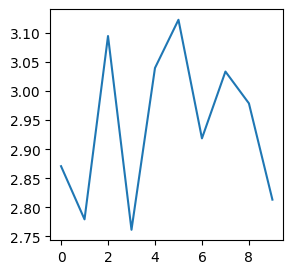

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(loss_list)

Save the Model

In [ ]:
torch.save(detector.state_dict(), "model.pt")